In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4" 
import torch
import open_clip
from diffusion_prior import *
from diffusers.utils import load_image
from IPython.display import display
from custom_pipeline import Generator4Embeds
from utils import *
from dataset import *
from networks import SimpleRegProb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/jc/miniconda3/envs/cocog/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vlmodel, _, preprocess = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-H-14')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vlmodel.to(device)
path_data = './data'
label_concept = torch.load(os.path.join(path_data, 'variables/label_dim.pt'))
dataset_plus = ImageDataPlus(os.path.join(path_data, 'things_plus'), preprocess)
# Load concept encoder
concept_encoder = SimpleRegProb(1024, 42, l1=0).to(device)
path_save = os.path.join(path_data, f'variables/emb_predict_SimpleReg.pt')
concept_encoder.load_state_dict(torch.load(path_save)['parameters'])

<All keys matched successfully>

In [3]:
h_embedding = vlmodel.encode_image(dataset_plus[0][0].to(device).unsqueeze(0)) # teddy_bear.jpg
c_embedding = concept_encoder(h_embedding.to(device)).detach().cpu()
image_feature = vlmodel.encode_image(dataset_plus[1][0].to(device).unsqueeze(0)) # cigarette_butt.jpg
concept_embedding = concept_encoder(image_feature.to(device)).detach().cpu()

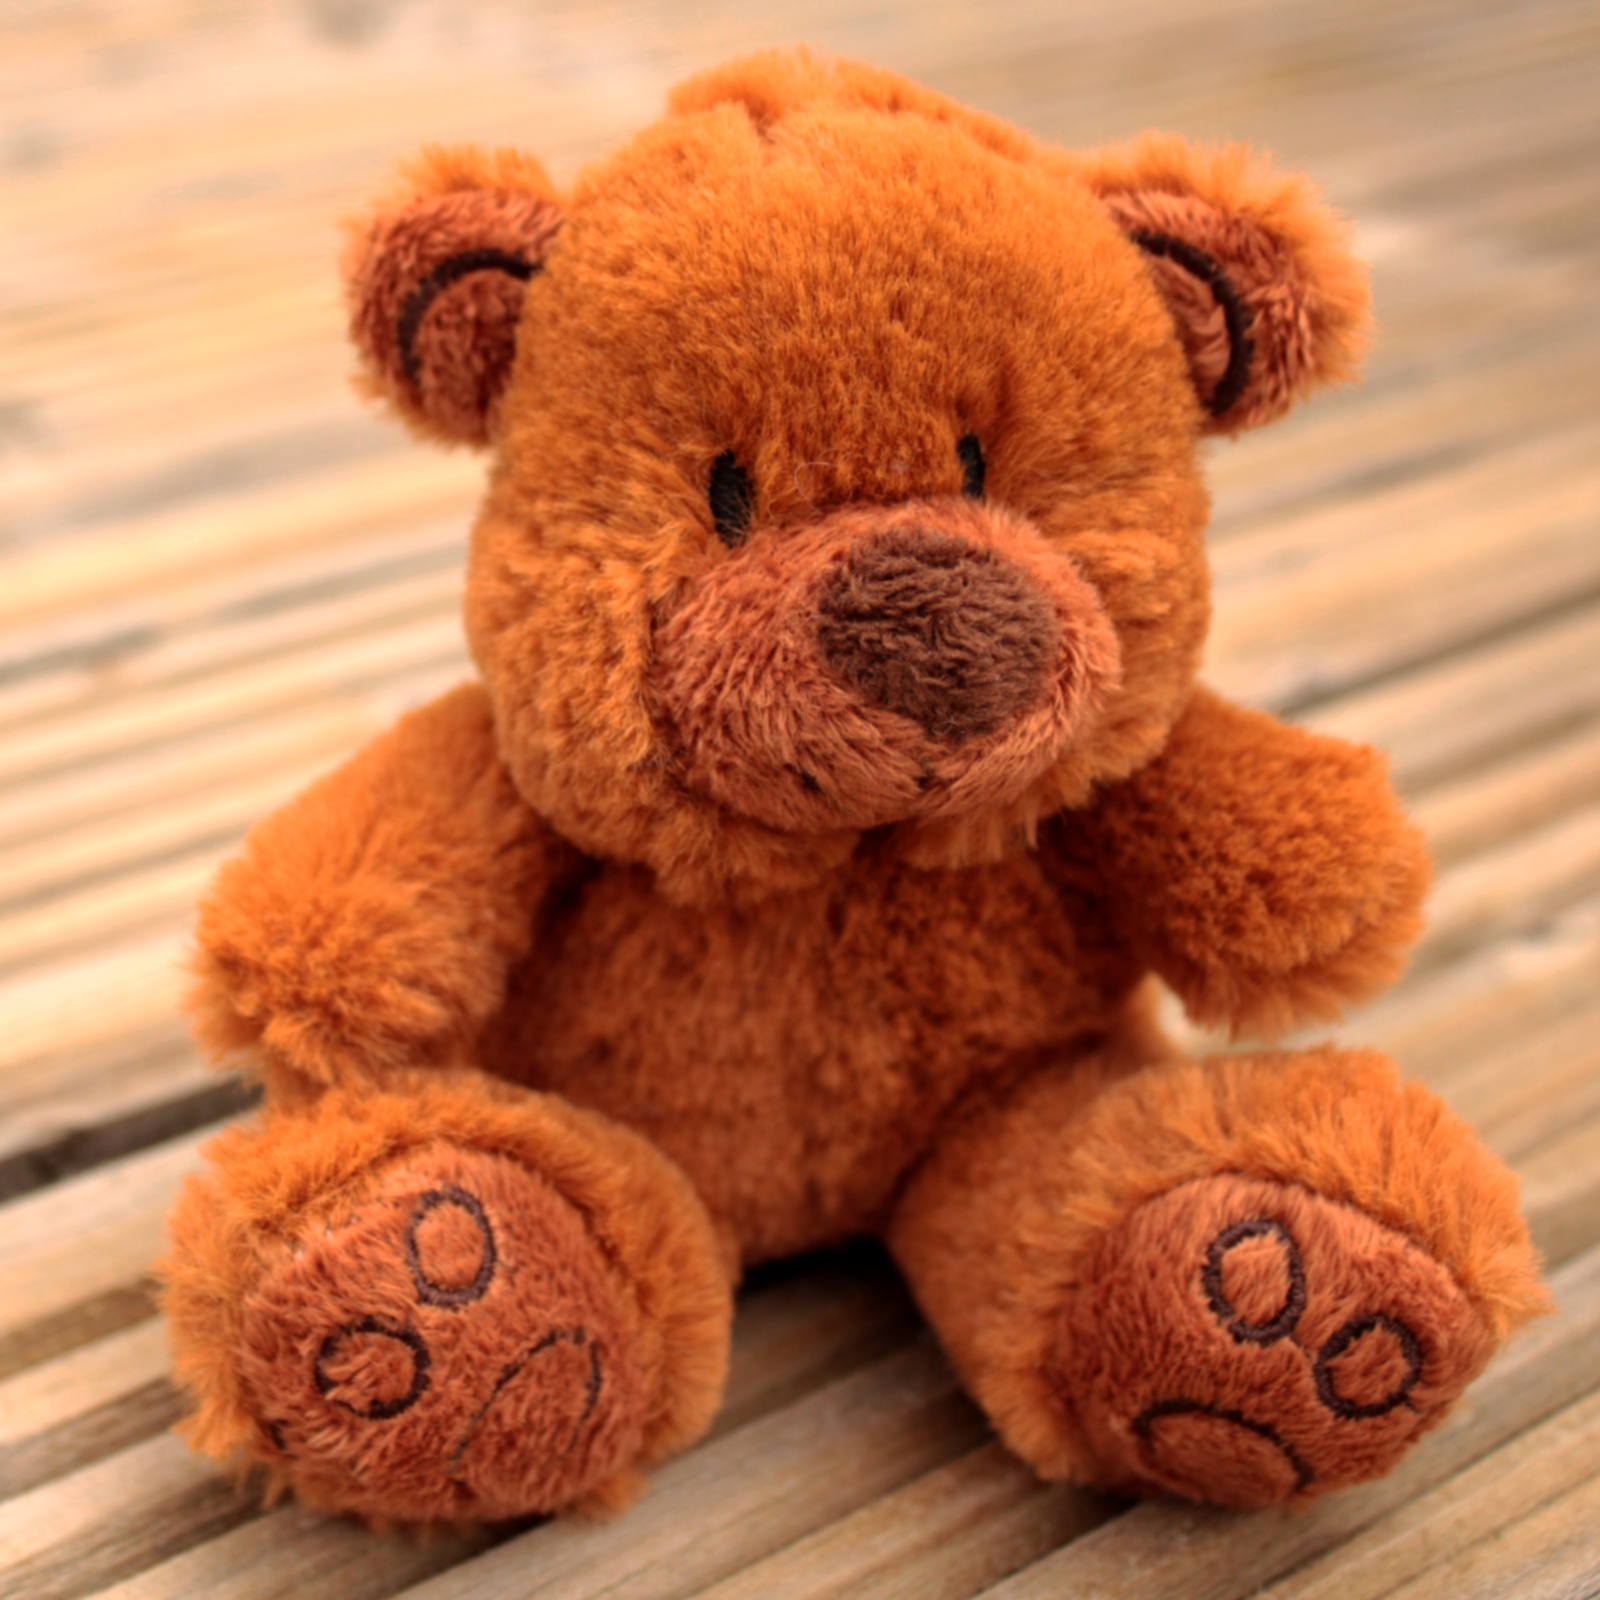

In [ ]:
image = Image.open(os.path.join(path_data, 'things_plus', "teddy_bear.jpg"))
display(image)

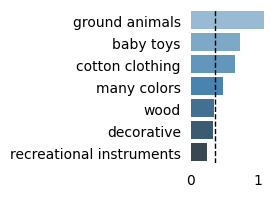

In [4]:
plot_bar(label_concept, c_embedding.squeeze())

In [5]:
## load diffusion prior
diffusion_prior = DiffusionPriorUNet(dropout=0.1)
# number of parameters
sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad)
pipe_prior = Pipe(diffusion_prior, device='cuda')
model_name = 'diffusion_prior_vice_pre_imagenet' # 'diffusion_prior_vice_pre_imagenet' or 'diffusion_prior_vice_pre'
pipe_prior.diffusion_prior.load_state_dict(torch.load(os.path.join(path_data,f'variables/{model_name}.pt')))

# Load image generator
pipe_image = Generator4Embeds(num_inference_steps=4)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...: 100%|██████████| 7/7 [00:14<00:00,  2.09s/it]
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


# Single image generation

50it [00:00, 219.47it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/jc/miniconda3/envs/cocog/lib/python3.12/site-packages/diffusers/models/embeddings.py:898: FutureWarning: You have passed a tensor as `image_embeds`.This is deprecated and will be removed in a future release. Please make sure to update your script to pass `image_embeds` as a list of tensors to supress this warning.
  deprecate("image_embeds not a list", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 4/4 [00:00<00:00,  8.38it/s]


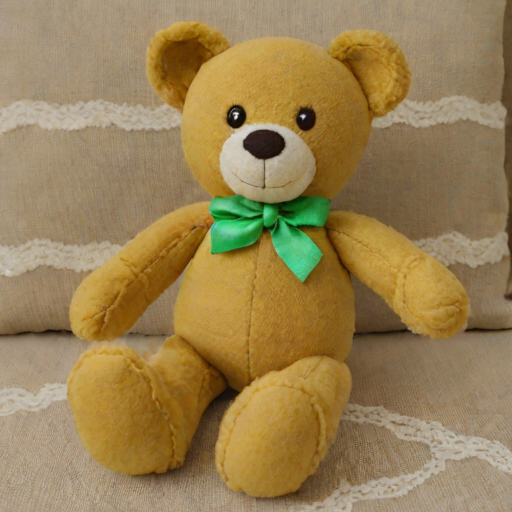

In [6]:
# generate single images from concept embeddings
h = pipe_prior.generate(c_embeds=c_embedding, num_inference_steps=50, guidance_scale=5.0)
image = pipe_image.generate(h.to(dtype=torch.float16))
display(image)

# Flexible controlling of generated objects with text prompts

In [7]:
# generate images from concept embeddings
def generate_image_from_concept(
        concept_embeds, 
        pipe_prior,
        pipe_image,
        guidance_scale=3.0,
        generator=None,
        text_prompt='',
        ip_adapter_scale=0.5,
    ):

    if text_prompt == '':
        pipe_image.pipe.set_ip_adapter_scale(1.0)
    else:
        pipe_image.pipe.set_ip_adapter_scale(ip_adapter_scale)
    # generate single images from concept embeddings
    h = pipe_prior.generate(
        c_embeds=concept_embeds, 
        num_inference_steps=50, 
        guidance_scale=guidance_scale, 
        generator=generator
    )
    image = pipe_image.generate(
        h.to(dtype=torch.float16),
        text_prompt=text_prompt,
        generator=generator,
    )
    return image

def concept_editor(concept_embeds, concept_edited, values, label_concept=None):
    # edit the concept_embeds according to the concept_edited and values

    # label_concept is neccesary if concept_edited[0] is str
    concept_embeds_edited = concept_embeds.clone() # (N, d)
    if concept_embeds_edited.dim() == 1:
        concept_embeds_edited = concept_embeds_edited.unsqueeze(0)
    values = torch.tensor(values, device=concept_embeds.device)

    # concept_edited is a list of concept indices or a list of concept names
    # find the concept indices if concept_edited is a list of concept names
    if isinstance(concept_edited[0], str):
        concept_edited = [label_concept.index(c) for c in concept_edited]

    # do the editing
    concept_embeds_edited[:, concept_edited] = values
    return concept_embeds_edited

50it [00:00, 301.32it/s]
100%|██████████| 4/4 [00:00<00:00, 15.23it/s]


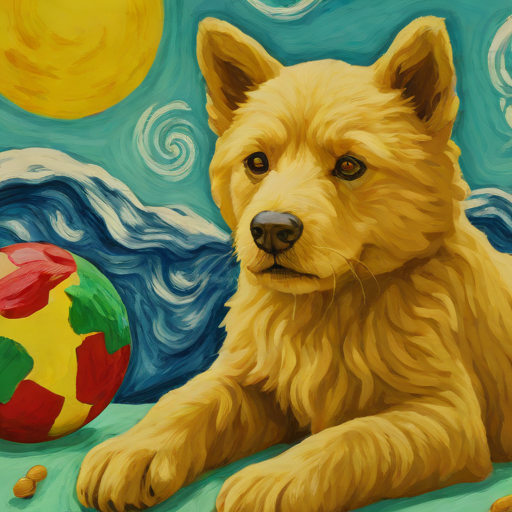

In [8]:
concept_edited = ['ground animals', 'cotton clothing', 'baby toys']
concept_embeddings = c_embedding.clone()
values = [1.8, 0.4, 0.12]
seed_value = 1
generator = torch.Generator(device=device)
concept_embeds_edited = concept_editor(concept_embeddings, concept_edited, values, label_concept)
generator.manual_seed(seed_value)
h = pipe_prior.generate(
    c_embeds=concept_embeds_edited, 
    num_inference_steps=50, 
    guidance_scale=3.0,
    generator=generator,
)
pipe_image.pipe.set_ip_adapter_scale(0.50)
image = pipe_image.generate(
    h.to(dtype=torch.float16),
    generator=generator,
    text_prompt='van gogh style',
)
display(image)

50it [00:00, 284.84it/s]
100%|██████████| 4/4 [00:00<00:00, 15.04it/s]


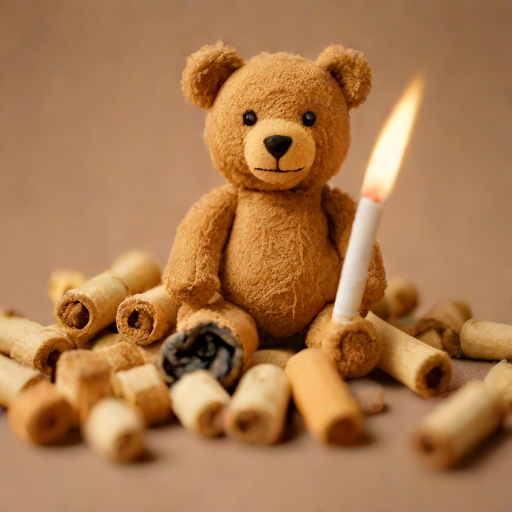

In [9]:
generator.manual_seed(seed_value)
image = generate_image_from_concept(
    concept_embedding,
    pipe_prior,
    pipe_image,
    guidance_scale=3,
    generator=generator,
    ip_adapter_scale=0.8,
    text_prompt='toy bear',
)
display(image)

# Manipulating the similarity judgment decisions by intervening the key concepts

In [11]:
# seed_value = torch.randint(100,(1,)).item()
seed_value = 1
generator = torch.Generator(device=device)
generator.manual_seed(seed_value)

In [12]:
num = [0, 1, 2, 5, 8, 11, 12, 13]
n = 16
images = []
for i in num:
    concept_edited = ['ground animals', 'cotton clothing', 'baby toys']
    values = [i*.15, (n-i)*.1, (n-i)*.03]
    print(values)
    concept_embeds_edited = concept_editor(c_embedding, concept_edited, values, label_concept)
    generator.manual_seed(seed_value)
    image = generate_image_from_concept(
        concept_embeds_edited,
        pipe_prior,
        pipe_image,
        guidance_scale=3,
        generator=generator,
        ip_adapter_scale=0.8,
        text_prompt='bear'
    )
    images.append(image)

[0.0, 1.6, 0.48]


0it [00:00, ?it/s]

50it [00:00, 291.44it/s]
100%|██████████| 4/4 [00:00<00:00, 14.74it/s]


[0.15, 1.5, 0.44999999999999996]


50it [00:00, 294.76it/s]
100%|██████████| 4/4 [00:00<00:00, 14.13it/s]


[0.3, 1.4000000000000001, 0.42]


50it [00:00, 295.37it/s]
100%|██████████| 4/4 [00:00<00:00, 14.67it/s]


[0.75, 1.1, 0.32999999999999996]


50it [00:00, 302.01it/s]
100%|██████████| 4/4 [00:00<00:00, 15.19it/s]


[1.2, 0.8, 0.24]


50it [00:00, 299.34it/s]
100%|██████████| 4/4 [00:00<00:00, 14.29it/s]


[1.65, 0.5, 0.15]


50it [00:00, 277.00it/s]
100%|██████████| 4/4 [00:00<00:00, 14.71it/s]


[1.7999999999999998, 0.4, 0.12]


50it [00:00, 304.86it/s]
100%|██████████| 4/4 [00:00<00:00, 15.20it/s]


[1.95, 0.30000000000000004, 0.09]


50it [00:00, 290.88it/s]
100%|██████████| 4/4 [00:00<00:00, 14.82it/s]


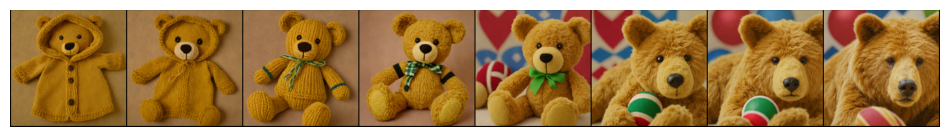

In [13]:
plot_indices_grid(images, shape=(1,8))